# Projet optimisation 

## Modélisation

Dans ce sujet, on cherche à chauffer un bâtiment résidentiel de sorte à minimiser la facture électrique du consommateur, tout en garantissant le  confot des occupants.

### 1. Ecrire la fonction objectif

L'objectif global est de minimiser la facture des occupants de la maison, cela revient à minimiser la fonction suivante.
$$\boxed{P(t)= \int_{t_0}^{t}{p}^{p/c}(t)w(t).dt}$$
- $t_0$ le temps initial
- $w(t)$ la charge souscrite à $t$
- $p_i^{p/c}(t)$ le prix de l'énergie à $t$ suivant si $t$ correspond à une heure pleine ou une heure creuse.
- $P(t)$ le montant de la facture entre $t_0$ et $t$ pour une consommation suivant la charge $w$ au prix $p$

### 2. Modélisation dynamique de la teméprature du bâtiment
On va considérer la maison comme un cube d'arrête $a$, et de face de surface $S=a^2$. On considère alors que les murs sont assez fins par rapport à la taille de l'édifice général pour que l'on puisse considérer la surface intérieure comme égale à la surface extérieure du cube. On alors $S_{ext} = S_{int} = 5.S$ (on considère qu'il n'y pas d'échange maison-sol). Onsuppose que les variations de températures sont quasistatiques.

> Les principales sources de perturbation extérieures de la température sont, l'apport d'énergie par le soleil par rayonnement , et l'appport par le chauffage, on compte aussi la perte d'energie au nieveau des murs.


Notons :
- $t$ le temps
- $T_{int}(t)$ la température de la maison supposée homogène
- $T_{ext}(t)$ la température extérieure
- $T_s(t)$ la température à la surface extérieure de la maison
- $\Phi_s(t)$ le flux solaire moyen($W/m^2$)
- $\Phi_{chauff}(t)$ le flux intérieur  produit par le chauffage
- $\Phi_{pertes}(t)$ le flux émis de l'intérieur vers l'extérieur 

On peut associer aux murs de la maison une résistance thermique telle que $\Delta_{int\to ext} = R_{th}\Phi_{pertes}$. Par exemple la résistance est donnée par $R_{th_i} = \frac{e}{\lambda S}$ dans le cadre unidimensionnel.

Si l'on considère une petite transformation pendant $dt$. 
L'écriture du premier principe à la maison {air à l'intérieur}  nous donne :
$$dU = C_{m}dT = Q_{chauffage} + Q_{Rayonnement}+ Q_{Pertes}$$
On néglige et $Q_{anthropique}$.
$$C_{m}dT = w(t)dt + \alpha \Phi_sS_{ext}dt+ \frac{T_{ext}-T}{R_{th}}dt$$
d'où:

$$\frac{dT}{dt} + \frac{T}{R_{th}C_{m}} =\frac{1}{C_{m}}\Bigg[w(t) +\alpha \Phi_sS_{ext} +\frac{T_{ext}}{R_{th}}  \Bigg]$$

### 3. Discrétisation du problème 

Dans le cadre général en notant $T_i = T(\tau i)$, si $\tau$ est suffisament petit devant les durées de variation de $w$, $\Phi_s$ et  on peut écrire :
$$\boxed{\Delta T= T_{i+1}-T_{i}=\frac{\tau}{C_{m}}[w(i\tau) +\alpha \Phi_s(\tau i )S_{ext} + \frac{T_{ext}(\tau i )}{R_{th}}]}$$

Dans le cadre des données fournies sur $OASIS$. on a $\forall t, w(t) = 0$.
D'où :
$$\Delta T= T_{i+1}-T_{i}=\frac{\tau}{C_{m}}[\alpha \Phi_s(\tau i )S_{ext} + \frac{T_{ext}(\tau i )}{R_{th}}]$$

Or si on fait l'hyphothèse d'une maison cubique de volume $V = S^{\frac{3}{2}}$. Or $C_m = C_{massique}\rho_{air}V =  C_{massique}\rho_{air}S^{\frac{3}{2}}$. 
D'où $S = (\frac{C_m}{C_{massique}\rho_{air}})^{\frac{2}{3}}$

Or on a $C_{massique} = 1004  J.K^{-1}kg^{-1}$ et $\rho_{air} = 1 \ kg.m^{-3}$
- On remarque que on connait l'évolution temporelle de la  température de la maison pour $W(t)=0$, ainsi que de la température extéireure et l'ensoleillemnent associé
- Les paramètres de notre problème sont  : 
    - La résistance thermique des murs
    - La capacité thermique de l'air dans notre maison. 
    - La part du rayonnement solaire qui arrive dans notre système
- On cherche donc les paramètres qui permettent d'approcher les différentes valeurs par une fonction de la forme présentée plus haut s
- On effectue pour cela une régression. 




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

Text(0.5, 1.0, 'température _ext')

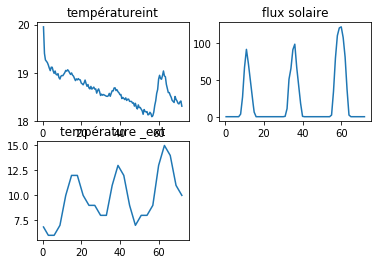

In [235]:
data = np.loadtxt('donnees-projet-gr4.txt')
heure = data.transpose()[0]
T_int = data.transpose()[1]
phi_sol = data.transpose()[2]
T_ext = data.transpose()[3]
plt.subplot((221))
plt.plot(heure,T_int)
plt.title('températureint')
plt.subplot((222))
plt.plot(heure,phi_sol)
plt.title('flux solaire')
plt.subplot(223)
plt.plot(heure,T_ext)
plt.title('température _ext')

In [236]:
N=10
triang_inf = np.zeros((N,N))
for i in range(0, N) :
        for j in range(i+1,N):
            triang_inf[i,j] = 1
triang_inf  = triang_inf.transpose()


In [294]:

print(T_int[0])
def mod(T_0,T_ext, Phi_sol,tau,R,C,alpha,a):
    S_ext = a**2*5
    V = a**3
    C = 1004*V
    model = [T_0]
    for i in range(1,len(T_ext)):
        diff =(3600*tau/C)*((alpha*Phi_sol[i])*S_ext-(model[-1]-T_ext[i])/R)
        model.append(model[-1] + diff)
        
    return model
    

19.9528634318898


In [295]:
def least_square(T_int, T_ext, phi_sol):
    def f(X):
        return np.linalg.norm(T_int-mod(T_int[0],T_ext,phi_sol,0.5,X[0],0,X[1],10))


    c2= optimize.NonlinearConstraint(lambda x : x[1],10**2*15*1004*1.204,10**2*15*1004*1.204)
    print('C',(5**2)*1004*1.204)
    res = optimize.minimize(f,[10,100], method = 'SLSQP')
    return res.x
R,C = least_square(T_int,T_ext, phi_sol)
print(R,C)

model = mod(T_int[0],T_ext, phi_sol,0.5,R,C)
plt.plot(heure,T_int)
plt.plot(heure,model)
print('S',C,(C/(1004*1.204))**(2/3))

C 30220.399999999998


TypeError: mod() missing 2 required positional arguments: 'alpha' and 'a'